In [18]:
library(magrittr)  # nice piping operators
library(tidyverse)  # tables, plotting, read-write
library(Cairo)  # for pdf unicode export
library(rasilabRtemplates)

# color blind palette
# http://www.cookbook-r.com/Graphs/Colors_(ggplot2)/#a-colorblind-friendly-palette
cbPalette <- c("#000000", "#E69F00", "#56B4E9", 
            "#009E73", "#CC79A7", "#0072B2", "#D55E00", "#F0E442")

### Figure 2E

In [19]:
annotations <- read_csv('../data/plate_reader/2e_glucose_ann.csv')
rawdata <- read_tsv('../data/plate_reader/2e_glucose_data.tsv')

Parsed with column specification:
cols(
  well = col_character(),
  sample_type = col_character(),
  strain = col_character(),
  time = col_integer(),
  glucose_ug = col_double()
)
Parsed with column specification:
cols(
  well = col_character(),
  Label1 = col_double(),
  time = col_datetime(format = ""),
  plate = col_integer()
)


In [20]:
# join rawdata with annotations
data <- rawdata %>%  
  left_join(annotations, by = 'well') %>% 
  select(-c(plate, well, time.x)) %>%
  rename(absorbance=Label1, time=time.y)

# remove empty wells
data <- data[!is.na(data$sample_type),]

# normalize to reagent blank
data <- data %>%
  mutate(absorbance = absorbance - 0.1914)

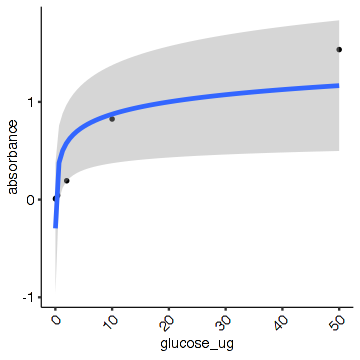

In [21]:
# plot standards
std_data <- subset(data, sample_type == 'standard')

plot.width = 3
plot.height = 3
options(repr.plot.width=plot.width, repr.plot.height=plot.height)

ggplot(std_data, aes(x=glucose_ug, y=absorbance)) +
geom_point(size=0.5) + theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
geom_smooth(method="lm", formula= y ~ log2(x))

In [22]:
# use standard curve to calculate an equation relating glucose quantity (ug) to absorbance
eqn <- lm(log(absorbance) ~ log(glucose_ug), data = subset(std_data))
eqn


Call:
lm(formula = log(absorbance) ~ log(glucose_ug), data = subset(std_data))

Coefficients:
    (Intercept)  log(glucose_ug)  
        -2.2190           0.7191  


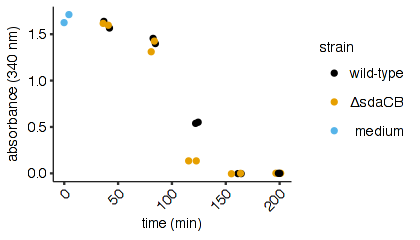

In [23]:
# plot sample absorbance
sample_data <- subset(data, sample_type == 'sample') %>%
  mutate(strain = factor(strain, levels=c('wild-type','sdaCB-','medium'))) %>%
  select(-c(glucose_ug))

plot.width = 3.5
plot.height = 2
options(repr.plot.width=plot.width, repr.plot.height=plot.height)

ggplot(sample_data, aes(x=time, y=absorbance, col=strain)) +
geom_point(size=1, position = position_jitter(w = 5, h = 0)) + 
theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
scale_colour_manual(values=cbPalette,labels=c("wild-type", expression(italic("ΔsdaCB")),
                                             "medium")) +
labs(x = "time (min)", y = "absorbance (340 nm)")

In [24]:
# for each sample, convert absorbance to glucose_ug
# multiplying by ten converts to ug/ml since reading is for 0.1ml of supernatant
sample_data$quantity <- 2^((log2(sample_data$absorbance) + 2.219)/0.7191)

# convert NaNs to zeroes
sample_data[is.na(sample_data)] <- 0

Warning message in eval(expr, envir, enclos):
“NaNs produced”

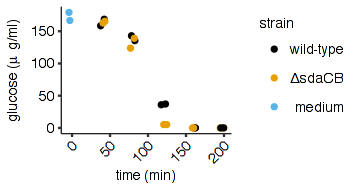

In [25]:
# plot sample quantity
plot.width = 3
plot.height = 1.6
options(repr.plot.width=plot.width, repr.plot.height=plot.height)

ggplot(sample_data, aes(x=time, y=quantity*10, col=strain)) +
geom_point(size=1, position = position_jitter(w = 5, h = 0)) + 
theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
scale_colour_manual(values=cbPalette,labels=c("wild-type", expression(italic("ΔsdaCB")),
                                             "medium")) +
labs(x = "time (min)", y = expression(paste("glucose (", mu, "g/ml)", sep="")))

ggsave('../pdf/fig_2e.pdf', width = plot.width, height = plot.height, units = 'in', device=cairo_pdf)

### Supp Figure 2C

In [35]:
annotations <- read_csv('../data/plate_reader/2e_growth_ann.csv')
rawdata <- read_tsv('../data/plate_reader/2e_growth_data.tsv')

processed_data <- rawdata %>%  
  left_join(annotations, by = c('well')) %>% 
  select(-c(date, strain, well)) %>%
  mutate(od = od - 0.04) %>%
  mutate(genotype = factor(genotype, levels=c("WT","sdaCB")))

Parsed with column specification:
cols(
  well = col_character(),
  strain = col_character(),
  genotype = col_character(),
  medium = col_character(),
  replicate = col_integer(),
  plate = col_integer()
)
Parsed with column specification:
cols(
  date = col_date(format = ""),
  plate = col_integer(),
  well = col_character(),
  time = col_double(),
  od = col_double()
)


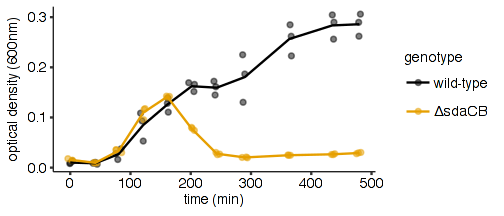

In [37]:
plot.width = 4.2
plot.height = 1.8
options(repr.plot.width=plot.width, repr.plot.height=plot.height)

ggplot(processed_data, aes(x=time, y=od, col=genotype)) +
geom_point(size=1, alpha=0.5, position = position_jitter(w = 5, h = 0)) +
scale_colour_manual(values=cbPalette, labels=c("wild-type", 
                                               expression(italic("ΔsdaCB")))) +
labs(x = "time (min)", y = "optical density (600nm)", col = "genotype") +
stat_summary(aes(group=genotype), fun.y=mean, geom="line")

ggsave('../pdf/supp_2c.pdf', width = plot.width, height = plot.height, units = 'in', device=cairo_pdf)